In [1]:
import warnings
warnings.filterwarnings('ignore')
#from keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15910774066008156658
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4689341831697522377
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
import os
import tensorflow as tf
import glob
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
#import tensorflow.contrib.eager as tfe
import numpy as np
from mode.annotation import *
from mode.box import *
from mode.darknet53 import *
from mode.generator import *
from mode.weights import *
from mode.yolohead import *
from mode.yolov3 import *
from mode.yololoss import *
import tensorflow as tf
from tensorflow.keras import backend as K
from PIL import Image, ImageFont, ImageDraw
import concurrent.futures
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from numba import jit
#from tensorflow.keras.backend import set_session 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf.test.is_gpu_available()
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [3]:
LABELS = ["方標"]
yolo_v3= Yolonet(n_classes=len(LABELS))
yolo_v3.load_weights("model"+'\\weights'+".h5")
COCO_ANCHORS = [10,13, 16,30, 33,23, 30,61, 62,45, 59,119, 116,90, 156,198, 373,326]
imgsize =1024
IMAGE_FOLDER = os.path.join( "data", "test_img","img3m.JPG")
    
img_fnames = glob.glob(IMAGE_FOLDER)
img = cv2.imread(img_fnames[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
def draw_cv2(scale_factor,img_scaled,boxes, labels, probs,class_labels,obj_thresh,desired_size):
    for box, label, prob in zip(boxes, labels, probs):
        label_str = class_labels[label]
        if prob > obj_thresh:
            print(label_str + ': ' + str(prob*100) + '%')
                
            # Todo: check this code
            if img_scaled.dtype == np.uint8:
                img_scaled = img_scaled.astype(np.int32)
            x1, y1, x2, y2 = (box * scale_factor).astype(np.int32)
            cv2.rectangle(img_scaled, (x1,y1), (x2,y2), (0,255,0), 1)
    return img_scaled
def draw_boxes_local_(image, boxes, labels, probs, class_labels, obj_thresh=0.0, desired_size=None):
    fontPath = r'C:\Windows\Fonts\kaiu.ttf'
    def _set_scale_factor():
        if desired_size:
            img_size = min(image.shape[:2])
            if img_size < desired_size:
                scale_factor = float(desired_size) / img_size
            else:
                scale_factor = 1.0
        else:
            scale_factor = 1.0
        return scale_factor
    scale_factor = _set_scale_factor()
    h, w = image.shape[:2]
    img_scaled = cv2.resize(image, (int(w*scale_factor), int(h*scale_factor)))
    img_scaled=draw_cv2(scale_factor,img_scaled,boxes, labels, probs,class_labels,obj_thresh,desired_size)
    return img_scaled 

In [5]:
def result_yolo_test(img,imgsize=416):
    try1=time.time()
    
    #imgs.append(img)
    boxes, labels, probs = yolo_v3.detect(img, COCO_ANCHORS,imgsize)
    coordinate.append([boxes,probs])
    or_numb.append([len(boxes)])
    #print(boxes, probs)
    #print(len(boxes))
    image = draw_boxes_local_(img, boxes, labels, probs, class_labels=LABELS, desired_size=400)
    image = np.asarray(image,dtype= np.uint8)
    plt.figure(figsize=(4, 4), dpi=200, tight_layout=True, linewidth=1, edgecolor='r')
    plt.imshow(image)
    plt.show()
    try2=time.time()
    print('{}'.format(try2-try1))
    return boxes, probs
def result_yolo_test_split(img,imgsize=416):
    try1=time.time()

    #imgs.append(img)
    boxes, labels, probs = yolo_v3.detect(img, COCO_ANCHORS,imgsize)
    coordinate_split.append([boxes,probs])
    #print(boxes, probs)
    split_numb.append(len(boxes))
    #print(len(boxes))
    image = draw_boxes_local_(img, boxes, labels, probs, class_labels=LABELS, desired_size=400)
    image = np.asarray(image,dtype= np.uint8)
    plt.figure(figsize=(4, 4), dpi=200, tight_layout=True, linewidth=1, edgecolor='r')
    plt.imshow(image)
    plt.show()
    try2=time.time()
    print('{}'.format(try2-try1))
    return boxes, probs

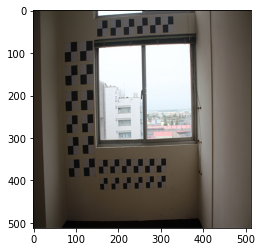

In [6]:
split_numb=[]
or_numb=[]
image = Image.open(img_fnames[0])
img = cv2.imread(img_fnames[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size=img.shape
img_size_width=img_size[1]
img_size_hight=img_size[0]
img_size_width_CUT=img_size_width//2
img_size_hight_CUT=img_size_hight//2
plt.imshow(img)
plt.show()

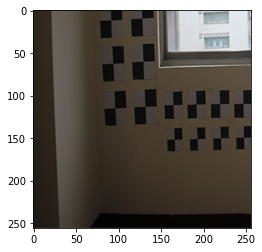

In [7]:
img_LT_coordinate = [0,img_size_width_CUT,0,img_size_hight_CUT]
img_LB_coordinate = [0,img_size_width_CUT,img_size_hight_CUT,img_size_hight_CUT+img_size_hight_CUT]


img_RT_coordinate = [img_size_width_CUT,img_size_width_CUT+img_size_width_CUT,0,img_size_hight_CUT]
img_RB_coordinate = [img_size_width_CUT,img_size_width,img_size_hight_CUT,img_size_hight]

all_img=img_LT_coordinate,img_LB_coordinate,img_RT_coordinate,img_RB_coordinate
LT = img_LT_coordinate
RT = img_RT_coordinate
LB = img_LB_coordinate
RB = img_RB_coordinate
crop_img_LT = img[LT[2]:LT[3], LT[0]:LT[1]]
crop_img_RT = img[RT[2]:RT[3],RT[0]:RT[1] ]
crop_img_LB = img[LB[2]:LB[3], LB[0]:LB[1]]
crop_img_RB = img[RB[2]:RB[3], RB[0]:RB[1]]

plt.imshow(crop_img_LB )
plt.show()

方標: 56.89758062362671%
方標: 52.693772315979004%
方標: 50.60393810272217%
方標: 58.46991539001465%
方標: 49.14778470993042%
方標: 58.53387713432312%
方標: 49.13136661052704%


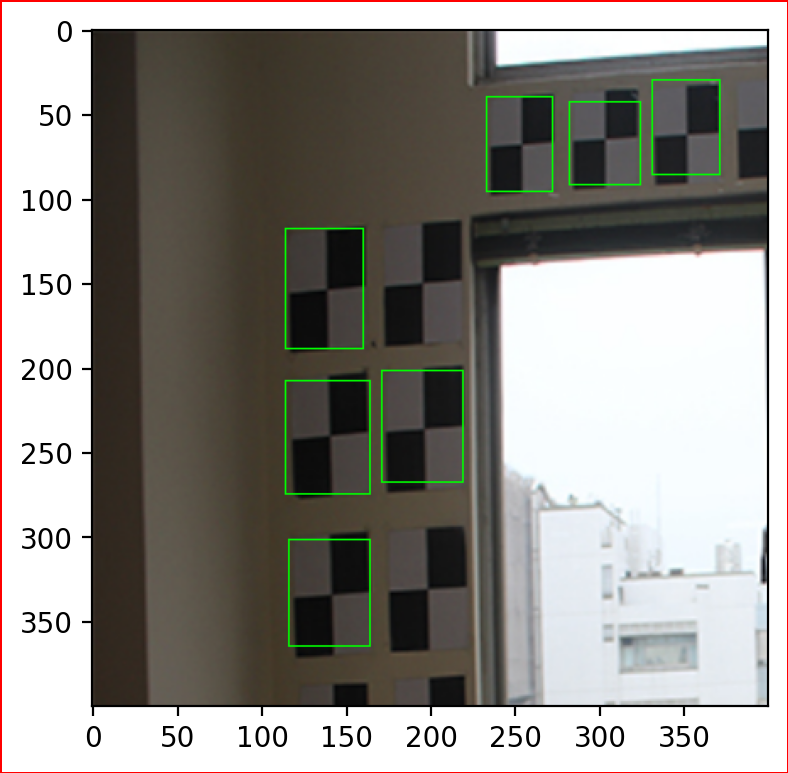

4.645194053649902
方標: 43.94925534725189%
方標: 22.043225169181824%


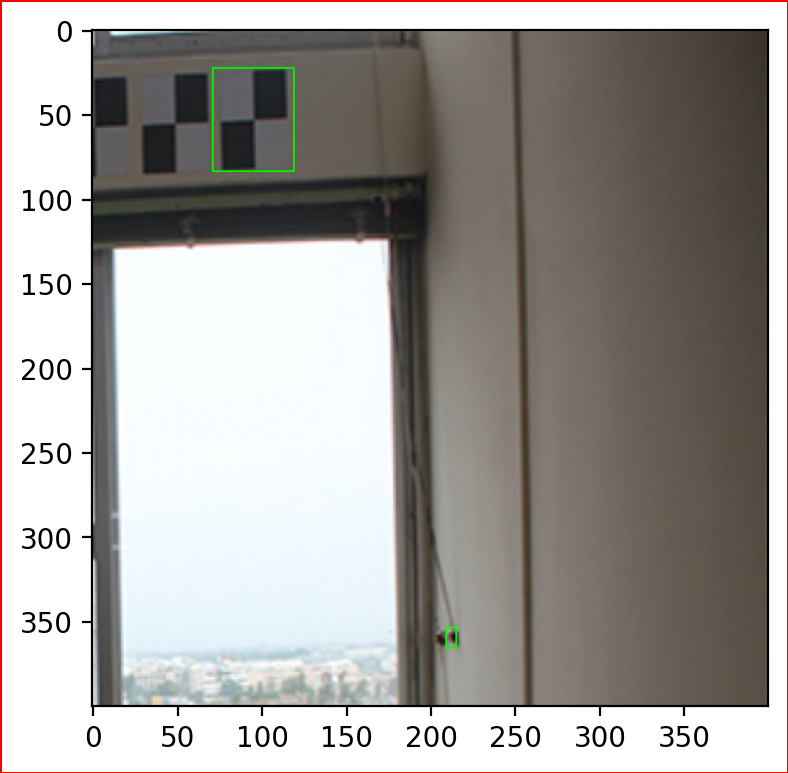

0.6403329372406006
方標: 42.144787311553955%
方標: 61.24074459075928%
方標: 64.75899815559387%
方標: 66.2684977054596%
方標: 56.476956605911255%
方標: 60.088181495666504%
方標: 64.49758410453796%


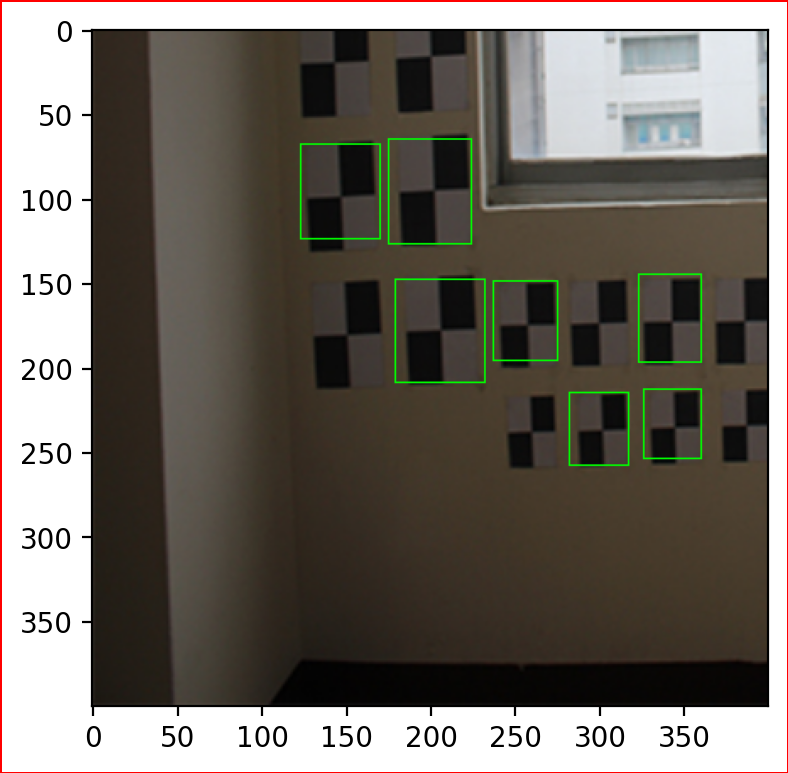

0.6555993556976318
方標: 65.45000672340393%
方標: 66.27547144889832%
方標: 66.97903871536255%
方標: 63.525402545928955%


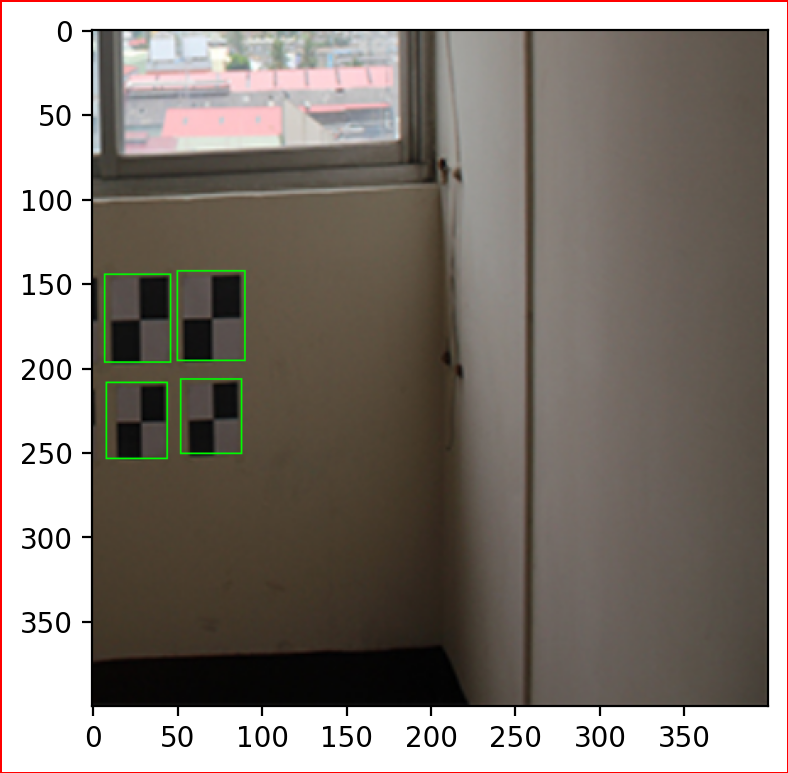

0.6565172672271729
方標: 42.2060489654541%
方標: 31.199941039085388%
方標: 33.83397459983826%
方標: 38.905900716781616%
方標: 39.15756940841675%
方標: 34.881263971328735%
方標: 25.29422640800476%
方標: 30.860596895217896%
方標: 39.59588706493378%
方標: 30.663758516311646%
方標: 30.88897168636322%
方標: 29.963865876197815%
方標: 32.85605311393738%
方標: 23.190313577651978%
方標: 23.325815796852112%
方標: 46.81186378002167%
方標: 48.4866589307785%
方標: 48.285189270973206%
方標: 44.3877637386322%
方標: 55.88696002960205%
方標: 19.033969938755035%
方標: 21.648024022579193%
方標: 34.9106639623642%
方標: 31.71040415763855%
方標: 44.69694197177887%
方標: 47.77259826660156%
方標: 47.61355817317963%


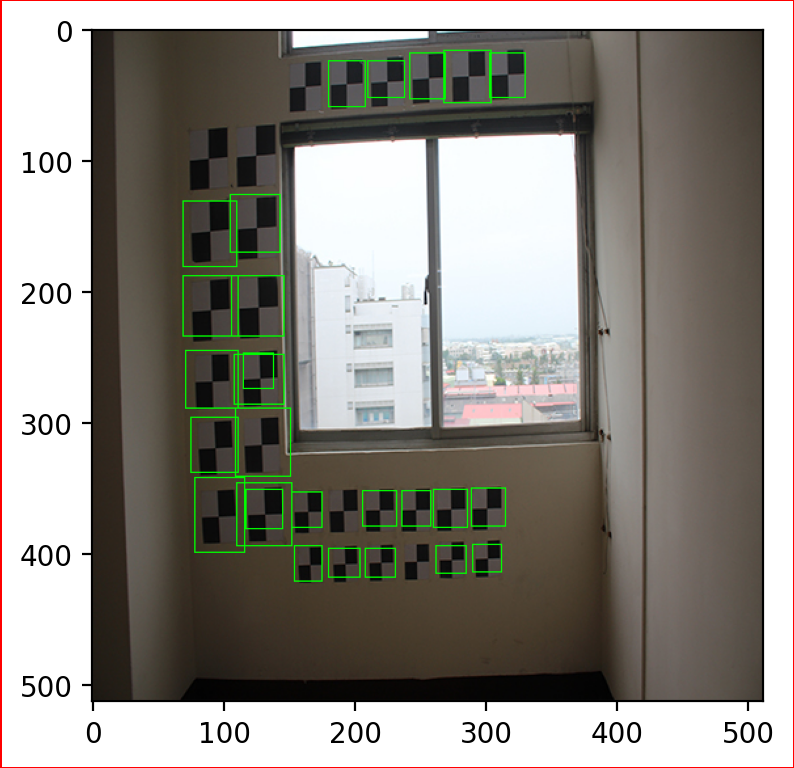

0.8319714069366455


In [8]:
coordinate=[]
result_yolo_test(crop_img_LT,imgsize)
result_yolo_test(crop_img_RT,imgsize)
result_yolo_test(crop_img_LB,imgsize)
result_yolo_test(crop_img_RB,imgsize)
result_yolo_test(img,imgsize)
copy_cood=coordinate.copy()




In [9]:
new_list=[]
continue_list=[]
for i in range(len(copy_cood)):
    for ii in zip(copy_cood[i][0],copy_cood[i][1]):
        continue_list.append(ii)
    new_list.append(continue_list) 

In [10]:
len(continue_list)

50

In [11]:
list_new=[]
for yolo_ob in continue_list:
    a=['方標','y:(top, bottom)',(int(yolo_ob[0][1]), int(yolo_ob[0][3])),'x:(left, right)',(int(yolo_ob[0][0]), int(yolo_ob[0][2])),'IOU值:',yolo_ob[1]]
    list_new.append(a)
    print(yolo_ob)

(array([212.,  19., 238.,  55.]), 0.5689758)
(array([149.5,  25. , 174.5,  61. ]), 0.5269377)
(array([180.5,  27.5, 207.5,  58.5]), 0.5060394)
(array([178.5,  23.5, 211.5,  62.5]), 0.0)
(array([ 73. ,  75.5, 103. , 120.5]), 0.58469915)
(array([109.5, 129. , 140.5, 171. ]), 0.49147785)
(array([ 73. , 132.5, 105. , 175.5]), 0.5853388)
(array([ 74.5, 193. , 105.5, 233. ]), 0.49131367)
(array([47.5, 18.5, 74.5, 49.5]), 0.0)
(array([45.5, 14.5, 76.5, 53.5]), 0.43949255)
(array([134., 226., 138., 234.]), 0.22043225)
(array([ 79.,  43., 109.,  79.]), 0.42144787)
(array([112.5,  41. , 143.5,  81. ]), 0.61240745)
(array([152.,  95., 176., 125.]), 0.64759)
(array([207. ,  92.5, 231. , 125.5]), 0.662685)
(array([115. ,  94.5, 149. , 133.5]), 0.56476957)
(array([181., 137., 203., 165.]), 0.6008818)
(array([209., 136., 231., 162.]), 0.64497584)
(array([  4.5,  92.5,  29.5, 125.5]), 0.65450007)
(array([ 32.,  91.,  58., 125.]), 0.6627547)
(array([  5.5, 133.5,  28.5, 162.5]), 0.6697904)
(array([ 33.

In [12]:
or_numb

[[8], [3], [7], [4], [28]]

In [13]:
len(list_new)

50

## 1.還原全部座標

In [14]:
or_numb

[[8], [3], [7], [4], [28]]

In [15]:
all_yolo=list_new[or_numb[0][0]+or_numb[1][0]+or_numb[2][0]+or_numb[3][0]:or_numb[0][0]+or_numb[1][0]+or_numb[2][0]+or_numb[3][0]+or_numb[4][0]]
crop_img_LT_list = list_new[0:or_numb[0][0]]
crop_img_RT_list = list_new[or_numb[0][0]:or_numb[0][0]+or_numb[1][0]]
crop_img_LB_list = list_new[or_numb[0][0]+or_numb[1][0]:or_numb[0][0]+or_numb[1][0]+or_numb[2][0]]
crop_img_RB_list = list_new[or_numb[0][0]+or_numb[1][0]+or_numb[2][0]:or_numb[0][0]+or_numb[1][0]+or_numb[2][0]+or_numb[3][0]]

In [16]:
#定義tuple可以可做改變
def list_add(a,b):
    c = []
    for i in range(len(a)):
        c.append(a[i]+b[i])
    return c
print('LB:')
for number,crop_img_LB_list_number in enumerate (crop_img_LB_list):
    crop_img_LB_list_number[2]= tuple(list_add(crop_img_LB_list_number[2],[img_size_hight_CUT,img_size_hight_CUT]))
    print(crop_img_LB_list_number)
print('RB:')
for numberRB,crop_img_RB_list_number in enumerate (crop_img_RB_list):
    crop_img_RB_list_number[2]= tuple(list_add(crop_img_RB_list_number[2],[img_size_hight_CUT,img_size_hight_CUT]))
    crop_img_RB_list_number[4]= tuple(list_add(crop_img_RB_list_number[4],[img_size_width_CUT,img_size_width_CUT]))
    print(crop_img_RB_list_number)
print('RT:')
for numberRT,crop_img_RT_list_number in enumerate (crop_img_RT_list):
    crop_img_RT_list_number[4]= tuple(list_add(crop_img_RT_list_number[4],[img_size_width_CUT,img_size_width_CUT]))
    print(crop_img_RT_list_number)

LB:
['方標', 'y:(top, bottom)', (299, 335), 'x:(left, right)', (79, 109), 'IOU值:', 0.42144787]
['方標', 'y:(top, bottom)', (297, 337), 'x:(left, right)', (112, 143), 'IOU值:', 0.61240745]
['方標', 'y:(top, bottom)', (351, 381), 'x:(left, right)', (152, 176), 'IOU值:', 0.64759]
['方標', 'y:(top, bottom)', (348, 381), 'x:(left, right)', (207, 231), 'IOU值:', 0.662685]
['方標', 'y:(top, bottom)', (350, 389), 'x:(left, right)', (115, 149), 'IOU值:', 0.56476957]
['方標', 'y:(top, bottom)', (393, 421), 'x:(left, right)', (181, 203), 'IOU值:', 0.6008818]
['方標', 'y:(top, bottom)', (392, 418), 'x:(left, right)', (209, 231), 'IOU值:', 0.64497584]
RB:
['方標', 'y:(top, bottom)', (348, 381), 'x:(left, right)', (260, 285), 'IOU值:', 0.65450007]
['方標', 'y:(top, bottom)', (347, 381), 'x:(left, right)', (288, 314), 'IOU值:', 0.6627547]
['方標', 'y:(top, bottom)', (389, 418), 'x:(left, right)', (261, 284), 'IOU值:', 0.6697904]
['方標', 'y:(top, bottom)', (388, 416), 'x:(left, right)', (289, 312), 'IOU值:', 0.635254]
RT:
['方標', 'y

In [17]:
total_coor=crop_img_LT_list+crop_img_LB_list+crop_img_RB_list+crop_img_RT_list+all_yolo

In [18]:
len(total_coor)

50

In [19]:
total_coor

[['方標',
  'y:(top, bottom)',
  (19, 55),
  'x:(left, right)',
  (212, 238),
  'IOU值:',
  0.5689758],
 ['方標',
  'y:(top, bottom)',
  (25, 61),
  'x:(left, right)',
  (149, 174),
  'IOU值:',
  0.5269377],
 ['方標',
  'y:(top, bottom)',
  (27, 58),
  'x:(left, right)',
  (180, 207),
  'IOU值:',
  0.5060394],
 ['方標',
  'y:(top, bottom)',
  (23, 62),
  'x:(left, right)',
  (178, 211),
  'IOU值:',
  0.0],
 ['方標',
  'y:(top, bottom)',
  (75, 120),
  'x:(left, right)',
  (73, 103),
  'IOU值:',
  0.58469915],
 ['方標',
  'y:(top, bottom)',
  (129, 171),
  'x:(left, right)',
  (109, 140),
  'IOU值:',
  0.49147785],
 ['方標',
  'y:(top, bottom)',
  (132, 175),
  'x:(left, right)',
  (73, 105),
  'IOU值:',
  0.5853388],
 ['方標',
  'y:(top, bottom)',
  (193, 233),
  'x:(left, right)',
  (74, 105),
  'IOU值:',
  0.49131367],
 ['方標',
  'y:(top, bottom)',
  (299, 335),
  'x:(left, right)',
  (79, 109),
  'IOU值:',
  0.42144787],
 ['方標',
  'y:(top, bottom)',
  (297, 337),
  'x:(left, right)',
  (112, 143),
  'IOU值:',

## 2.找出分割

In [20]:
YOLO_ALL_object=[]
for yolo_ob in total_coor:
    if yolo_ob[2][0] <img_size_hight_CUT and yolo_ob[2][1] >img_size_hight_CUT:
        YOLO_ALL_object.append(yolo_ob)
    elif yolo_ob[4][0] <img_size_width_CUT and yolo_ob[4][1] >img_size_width_CUT:
        YOLO_ALL_object.append(yolo_ob)  

In [21]:
left_list_range=[]
right_list_range=[]
top_list_range=[]
bottom_list_range=[]
for YOLO_range in YOLO_ALL_object:
    top_list_range.append(YOLO_range[2][0])
    bottom_list_range.append(YOLO_range[2][1])
    left_list_range.append(YOLO_range[4][0])
    right_list_range.append(YOLO_range[4][1])

In [22]:
min_left=int(min(left_list_range, default=0))-15
min_right=int(max(right_list_range, default=0))+15
min_top=int(min(top_list_range, default=0))-15
min_bottom=int(max(bottom_list_range, default=0))+15
crop_img_yolo = img[min_top:min_bottom, min_left:min_right]

#plt.imshow(crop_img_yolo )
#plt.show()

方標: 69.20061111450195%
方標: 63.91706466674805%
方標: 64.0560507774353%
方標: 63.69172930717468%
方標: 58.21644067764282%
方標: 52.627867460250854%
方標: 63.75299692153931%
方標: 59.98726487159729%
方標: 65.13936519622803%
方標: 57.554298639297485%
方標: 68.48345994949341%
方標: 66.63883924484253%
方標: 70.01436948776245%
方標: 66.27527475357056%
方標: 70.27881741523743%
方標: 72.53521084785461%
方標: 67.89372563362122%
方標: 68.6596155166626%
方標: 64.03142213821411%
方標: 65.70076942443848%
方標: 62.11100220680237%


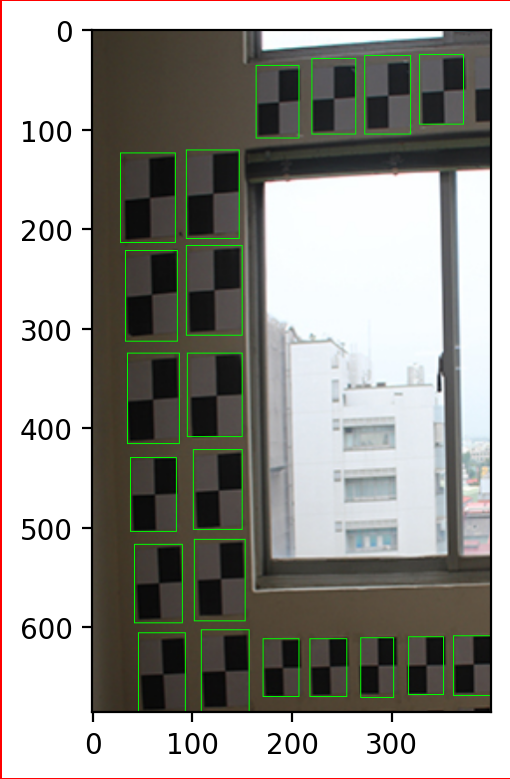

0.6093699932098389
after exception....


In [23]:
coordinate_split=[]
split_list=[]
try:
    result_yolo_test_split(crop_img_yolo,1024)
    for yolo_ob in zip(coordinate_split[0][0],coordinate_split[0][1]):
        a=['方標','y:(top, bottom)',(int(yolo_ob[0][1]), int(yolo_ob[0][3])),'x:(left, right)',(int(yolo_ob[0][0]), int(yolo_ob[0][2])),'IOU值:',yolo_ob[1]]
        split_list.append(a)
except:
    print("空白")
print("after exception....")


In [24]:
len(split_list)

22

## 還原被分割物的座標

In [25]:
px=0
for list_pic_for2 in split_list:
    #print(list_pic_for2)
    list_pic_for2[2]= tuple(list_add(list_pic_for2[2],[min_top-px,min_top-px]))
    list_pic_for2[4]= tuple(list_add(list_pic_for2[4],[min_left,min_left]))
    print(list_pic_for2) 
    
remove_split=[]
for i in split_list:
    if i[6]==0:
        remove_split.append(i) 
for out_del in remove_split:
    split_list.remove(out_del)

['方標', 'y:(top, bottom)', (16, 56), 'x:(left, right)', (243, 268), 'IOU值:', 0.6920061]
['方標', 'y:(top, bottom)', (22, 64), 'x:(left, right)', (150, 174), 'IOU值:', 0.63917065]
['方標', 'y:(top, bottom)', (18, 61), 'x:(left, right)', (181, 206), 'IOU值:', 0.6405605]
['方標', 'y:(top, bottom)', (16, 61), 'x:(left, right)', (212, 238), 'IOU值:', 0.6369173]
['方標', 'y:(top, bottom)', (72, 123), 'x:(left, right)', (72, 103), 'IOU值:', 0.5821644]
['方標', 'y:(top, bottom)', (70, 121), 'x:(left, right)', (110, 140), 'IOU值:', 0.5262787]
['方標', 'y:(top, bottom)', (68, 121), 'x:(left, right)', (111, 138), 'IOU值:', 0.0]
['方標', 'y:(top, bottom)', (128, 180), 'x:(left, right)', (75, 105), 'IOU值:', 0.63752997]
['方標', 'y:(top, bottom)', (125, 176), 'x:(left, right)', (110, 142), 'IOU值:', 0.59987265]
['方標', 'y:(top, bottom)', (187, 239), 'x:(left, right)', (76, 106), 'IOU值:', 0.65139365]
['方標', 'y:(top, bottom)', (187, 235), 'x:(left, right)', (110, 141), 'IOU值:', 0.575543]
['方標', 'y:(top, bottom)', (247, 289), 

In [26]:
ALL_OBJRCT=total_coor

In [27]:
len(ALL_OBJRCT)

50

In [28]:

remove_cut_all=[]
for all_yolo_ob in ALL_OBJRCT:
    print(all_yolo_ob)
    if all_yolo_ob[2][0]>= min_top-px and all_yolo_ob[2][1]<= min_bottom+px and all_yolo_ob[4][0]>= min_left and all_yolo_ob[4][1]<= min_right+px:
        remove_cut_all.append(all_yolo_ob)

['方標', 'y:(top, bottom)', (19, 55), 'x:(left, right)', (212, 238), 'IOU值:', 0.5689758]
['方標', 'y:(top, bottom)', (25, 61), 'x:(left, right)', (149, 174), 'IOU值:', 0.5269377]
['方標', 'y:(top, bottom)', (27, 58), 'x:(left, right)', (180, 207), 'IOU值:', 0.5060394]
['方標', 'y:(top, bottom)', (23, 62), 'x:(left, right)', (178, 211), 'IOU值:', 0.0]
['方標', 'y:(top, bottom)', (75, 120), 'x:(left, right)', (73, 103), 'IOU值:', 0.58469915]
['方標', 'y:(top, bottom)', (129, 171), 'x:(left, right)', (109, 140), 'IOU值:', 0.49147785]
['方標', 'y:(top, bottom)', (132, 175), 'x:(left, right)', (73, 105), 'IOU值:', 0.5853388]
['方標', 'y:(top, bottom)', (193, 233), 'x:(left, right)', (74, 105), 'IOU值:', 0.49131367]
['方標', 'y:(top, bottom)', (299, 335), 'x:(left, right)', (79, 109), 'IOU值:', 0.42144787]
['方標', 'y:(top, bottom)', (297, 337), 'x:(left, right)', (112, 143), 'IOU值:', 0.61240745]
['方標', 'y:(top, bottom)', (351, 381), 'x:(left, right)', (152, 176), 'IOU值:', 0.64759]
['方標', 'y:(top, bottom)', (348, 381),

In [29]:
ALL_OBJRCT1=ALL_OBJRCT.copy()
for cut_remove_cut_all in remove_cut_all:
    print(cut_remove_cut_all)
    ALL_OBJRCT1.remove(cut_remove_cut_all)

['方標', 'y:(top, bottom)', (19, 55), 'x:(left, right)', (212, 238), 'IOU值:', 0.5689758]
['方標', 'y:(top, bottom)', (25, 61), 'x:(left, right)', (149, 174), 'IOU值:', 0.5269377]
['方標', 'y:(top, bottom)', (27, 58), 'x:(left, right)', (180, 207), 'IOU值:', 0.5060394]
['方標', 'y:(top, bottom)', (23, 62), 'x:(left, right)', (178, 211), 'IOU值:', 0.0]
['方標', 'y:(top, bottom)', (75, 120), 'x:(left, right)', (73, 103), 'IOU值:', 0.58469915]
['方標', 'y:(top, bottom)', (129, 171), 'x:(left, right)', (109, 140), 'IOU值:', 0.49147785]
['方標', 'y:(top, bottom)', (132, 175), 'x:(left, right)', (73, 105), 'IOU值:', 0.5853388]
['方標', 'y:(top, bottom)', (193, 233), 'x:(left, right)', (74, 105), 'IOU值:', 0.49131367]
['方標', 'y:(top, bottom)', (299, 335), 'x:(left, right)', (79, 109), 'IOU值:', 0.42144787]
['方標', 'y:(top, bottom)', (297, 337), 'x:(left, right)', (112, 143), 'IOU值:', 0.61240745]
['方標', 'y:(top, bottom)', (351, 381), 'x:(left, right)', (152, 176), 'IOU值:', 0.64759]
['方標', 'y:(top, bottom)', (348, 381),

In [30]:
len(ALL_OBJRCT1)

20

In [31]:
len(split_list)

21

In [32]:
ALL_OBJRCT12=ALL_OBJRCT1.copy()

In [33]:
del_list=[]
for i in ALL_OBJRCT12:
    if i[6]<0.2:
        del_list.append(i) 
        
for out_del in del_list:
    ALL_OBJRCT12.remove(out_del)
        

In [34]:
all_list=ALL_OBJRCT12+split_list

In [35]:
all_list1=all_list.copy()

In [36]:
ALL=[]
imgw_h_range=25
for all_ob in all_list1:
    #print(all_ob)
    if abs((all_ob[2][1]-all_ob[2][0])-(all_ob[4][1]-all_ob[4][0]))<imgw_h_range:
        ALL.append(all_ob)

In [37]:
len(all_yolo),len(ALL)

(28, 38)

In [38]:
overlapping=[]
for i in ALL:
    for ii in ALL:
        if ii[4][0]<i[4][0] and ii[4][1]>i[4][0] and ii[2][0]<i[2][0] and ii[2][1]>i[2][0]:
            if i[-1]>=ii[-1]:
                overlapping.append(ii) 
            else:
                overlapping.append(i)
        if ii[4][0]>=i[4][0] and ii[4][1]<i[4][1] and ii[2][0]<=i[2][1] :
            overlapping.append(i)

try:                
    for cut_remove_cut_all in overlapping:
        ALL.remove(cut_remove_cut_all)
except:
    print("空白")

空白


In [39]:
len(ALL)

31

In [40]:
img.shape

(512, 512, 3)

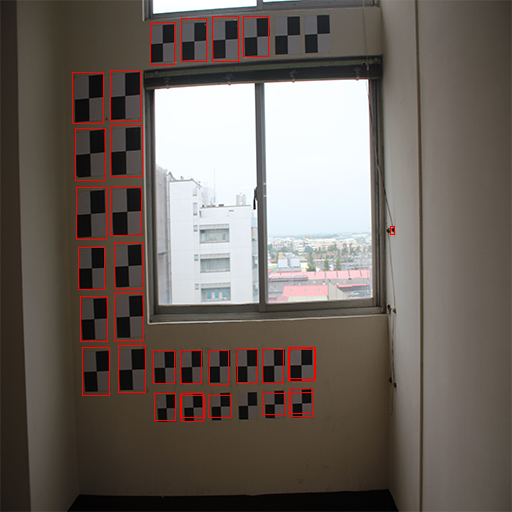

In [41]:
image1=image.copy()
obj_thresh=0
if len(all_yolo)>0 or len(ALL)>0:

    if len(all_yolo)>len(ALL) or len(all_yolo)==len(ALL):
        for draw_all in all_yolo:
            plt_all=[(draw_all[4][0], draw_all[2][0]),(draw_all[4][1], draw_all[2][1])]

            img1 = ImageDraw.Draw(image1)   
            img1.rectangle(plt_all,  outline ="red") 
    else:
        for draw_all in ALL:
            plt_all=[(draw_all[4][0], draw_all[2][0]),(draw_all[4][1], draw_all[2][1])]

            img1 = ImageDraw.Draw(image1)   
            img1.rectangle(plt_all,  outline ="red") 
else:
    
    box,pro=result_yolo_test(img,416)
    for draw_all,pro_ in zip(box,pro) :
        if pro_> obj_thresh:
            print(draw_all)
            plt_all=[(draw_all[0], draw_all[1]),(draw_all[2], draw_all[3])]
            img1 = ImageDraw.Draw(image1) 
            img1.rectangle(plt_all,  outline ="red") 
    
image1

In [42]:
image1.save('1.jpg')